# Variational Monte Carlo
### For a 4 Particle System

In [146]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output


from pdb import set_trace

In [85]:
# 1 is up and 0 is down
# these are all the possible ground configurations that might
# contribute to the ground states

# this version makes it readable
states = np.asarray([
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0],
])

# this line turns all the 0s to -1s for computational purposes
states = states*2; states=states - 1; states

array([[ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [ 1, -1,  1, -1],
       [-1,  1, -1,  1],
       [ 1, -1, -1,  1],
       [-1,  1,  1, -1]])

In [3]:
def get_random_state():
    return random.choice(states)

In [95]:
def get_variational_projection(state, alpha):
    """
    This function computes the projection of state in the spin basis
    onto the varitional wave function
    """
    exponent = 0 
    # FOO DO WE COUNT THE SUMS TWICE?
    for i in range(len(state)):
        for j in range(len(state)):
            if i is not j:
                exponent += -1*(alpha/abs(i-j))*state[i]*state[j]
    return math.exp(exponent)

In [112]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            if state[i] != state[0]:
                state_copy[i] *= -1
                state_copy[0] *= -1
                off_diagonal_configurations.append(state_copy)
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()

In [113]:
def calculate_local_energy(state, alpha):
    """
    This function calculates the local energy of a state
    """
    # contribution from Z direction spin terms
    energy = 0
    variational_projection = get_variational_projection(state, alpha) # (The 1 is the h-bar, which is one in our units)
    energy += variational_projection * (len(state)/4)
    
    # contributions from off diagonal terms
    for configuration_state in get_off_diagonal_configurations(state):
        energy += get_variational_projection(configuration_state, alpha)*(1/8)
    return energy / variational_projection

In [114]:
def compute_R(trial_state, initial_state, alpha):
    """
    Function compute "R", which is the ratio between the weight functions
    of the initial state and the trial state.
    """
    numerator = variational_projection(trial_state, alpha) **2
    denominator = variational_projection(initial_state, alpha) **2
    return numerator / denominator

In [115]:
def random_flip(state):
    """
    Randomly flips two bits of a state such
    that there are still two up and two down
    """
    choices = random.sample(list(range(0,len(state))), len(state))
    flip1_index = choices.pop()
    flip1_value = state[flip1_index]
    state[flip1_index] *= -1
    cont = True
    while(cont):
        flip2_index = choices.pop()
        if state[flip2_index] != flip1_value:
            state[flip2_indfrom IPython.display import clear_output
ex] *= -1
            cont = False
    return state

In [116]:
def monte_carlo_estimation(alpha, num_steps):
    x_initial = get_random_state()
    running_total = 0
    for i in range(num_steps):
        x_trial = random_flip(x_initial)
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial
        running_total += calculate_local_energy(x_initial, alpha)
    return running_total / num_steps

In [169]:
def get_optimal_alpha(alphas, num_steps=50000):
    energies = list()
    for i, alpha in enumerate(alphas):
        clear_output(wait=True)
        print(f"Alpha: {i+1}/{len(alphas)}")
        energies.append(monte_carlo_estimation(alpha, num_steps))
    return alphas[np.argmin(energies)], energies

Alpha: 4/4


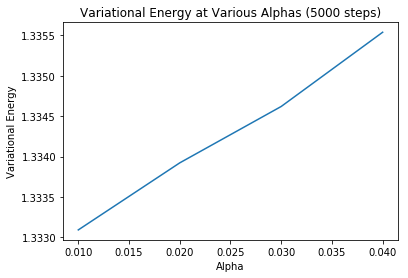

Optimal Alpha found at 0.01


In [170]:
alphas = [i*0.01 for i in range(1,5)]
optimal_alpha, energies = get_optimal_alpha(alphas)

plt.plot(alphas, energies)
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title("Variational Energy at Various Alphas (5000 steps)")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")

Alpha: 9/9


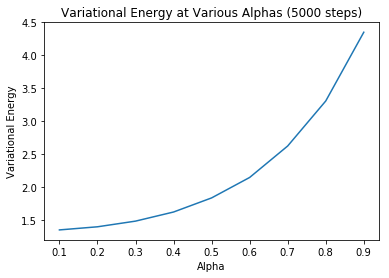

Optimal Alpha found at 0.1


In [171]:
alphas = [i*0.1 for i in range(1,10)]
optimal_alpha, energies = get_optimal_alpha(alphas)

plt.plot(alphas, energies)
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title("Variational Energy at Various Alphas (5000 steps)")
plt.show()
print(f"Optimal Alpha found at {optimal_alpha}")